# Add visualisation

The following code visualises add plots

In [18]:
from dsvr.datasets.robot_data import RoboticsDatasetV2
from dsvr.results.robot_results import VisionInferenceResultV3, ADDResultV2
from assembly.utils.experiment_utils import compute_add_new
from assembly.utils.descriptions import rectangle
import trimesh
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
icp_results_path = "/root/workspace/output/October2025/21/16/icp/results/vision_results.npz"
fp_results_path = "/root/workspace/fp/vision_inference_results.npz"
bc_pf_results_path = "/root/workspace/output/November2025/04/10/sir/results/vis_results.npz"
dataset_path = "/root/workspace/output/October2025/20/14/noisy_image_data/data/dataset.npz"

ds = RoboticsDatasetV2.load(dataset_path)
icp_res = VisionInferenceResultV3.load(icp_results_path)
fp_res = VisionInferenceResultV3.load(fp_results_path)
bc_pf_res = VisionInferenceResultV3.load(bc_pf_results_path)


In [15]:
cam_times, cam_transforms = ds.se3_traj['X_Camera']
hole_times, hole_transforms = ds.se3_traj['X_Hole']
print(hole_transforms[0])
gt_pose = hole_transforms[0]

[[1.   0.   0.   0.55]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]]


In [6]:
print(icp_res.summary())
print(fp_res.summary())
print(bc_pf_res.summary())

VisionInferenceResult (hierarchical):
  Measurements (K): 500
  Particles per measurement (N): 3
  Pose shape: (4, 4)
  Image shape: (480, 640, 1), dtype=float64
  Time range: (0.0, 4.99)
  Measurement ID range: (0, 499)
  Unnormalised log-pdf range: (0.0, 0.0)
VisionInferenceResult (hierarchical):
  Measurements (K): 50
  Particles per measurement (N): 1
  Pose shape: (4, 4)
  Image shape: (480, 640, 1), dtype=float64
  Time range: (0.0, 49.0)
  Measurement ID range: (0, 49)
  Unnormalised log-pdf range: (0.0, 0.0)
VisionInferenceResult (hierarchical):
  Measurements (K): 50
  Particles per measurement (N): 10
  Pose shape: (4, 4)
  Image shape: (480, 640, 1), dtype=float32
  Time range: (0.0, 4.9)
  Measurement ID range: (0, 49)
  Unnormalised log-pdf range: (929.0159912109375, 1055.7777099609375)


## Visualise VisionInference results

- [ ] Iterate through results and compute ADD
- [ ] Visualise ADD vs time
- [ ] Visualise min ADD as bar plots between various methods

In [61]:
def Rt_from_T(T: np.ndarray):
    """Extract (R, t) from a 4x4 pose."""
    R = T[:3, :3]
    t = T[:3, 3]
    return R, t

def compute_add_over_time(
    result: VisionInferenceResultV3,
    gt_pose: np.ndarray,        # ( 4, 4)
    model_mesh_path: str,
    n_model_points: int = 2000,
):
    """
    Returns:
        times_k           (K,)
        add_mean          (K,)
        add_min           (K,)
        add_best_weighted (K,)
    """

    # Load model points
    mesh = trimesh.load(model_mesh_path, force="mesh")
    model_points = mesh.sample(n_model_points)

    K, N = result.K, result.N

    times_k = np.zeros(K)
    add_mean = np.zeros(K)
    add_min = np.zeros(K)
    add_best_weighted = np.zeros(K)
    adds_k = np.zeros((K, N))

    for k in range(K):
        meas = result.get_measurement(k)

        R_gt, t_gt = Rt_from_T(gt_pose)

        adds = np.zeros(N)
        for i in range(N):
            R_est, t_est = Rt_from_T(meas["poses"][i])
            adds[i] = compute_add_new(
                R_gt, t_gt, R_est, t_est, model_points
            )

        # Aggregate
        times_k[k] = np.mean(meas["times"])
        add_mean[k] = np.mean(adds)
        add_min[k] = np.min(adds)
        adds_k[k] = adds

        best_idx = np.argmin(meas["unnormalised_log_pdfs"])
        add_best_weighted[k] = adds[best_idx]

    return times_k, adds_k, add_mean, add_min, add_best_weighted

def plot_add_vs_time(times, add_mean, add_min, add_best, title):
    plt.figure(figsize=(7, 4))

    plt.plot(times, add_mean, label="Mean ADD", linewidth=2)
    plt.plot(times, add_best, label="Best-particle ADD", linewidth=2)
    plt.plot(times, add_min, label="Min ADD", linestyle="--")

    plt.xlabel("Time (s)")
    plt.ylabel("ADD")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### ICP

Visualise results for ICP registration

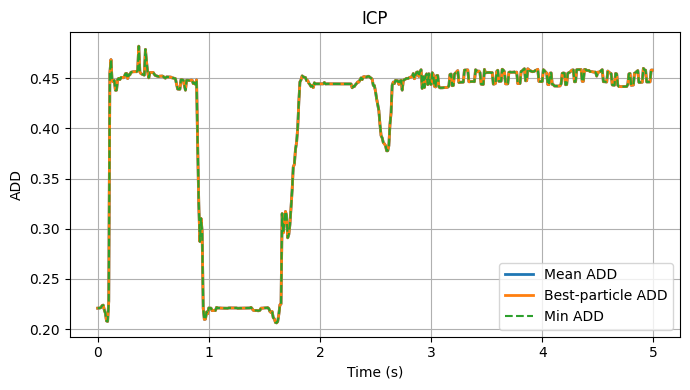

In [62]:
times, icp_adds, icp_add_mean, icp_add_min, icp_add_best = compute_add_over_time(
        icp_res,
        gt_pose=gt_pose,
        model_mesh_path=rectangle.HOLE_OBJ,
        n_model_points=3000,
    )

plot_add_vs_time(times,icp_add_mean, icp_add_min, icp_add_best, title="ICP")

### FP

Visualise results for FoundationPose

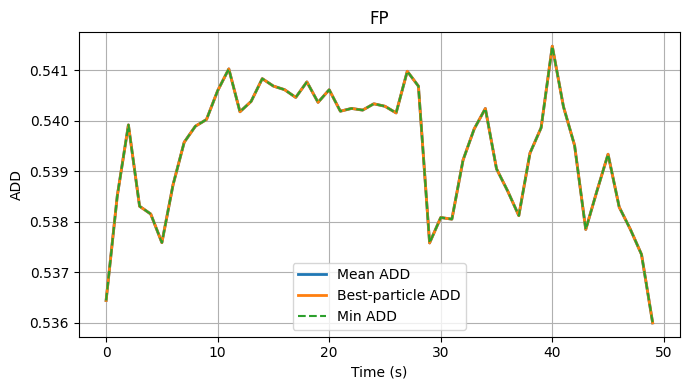

In [63]:
times, fp_adds, fp_add_mean, fp_add_min, fp_add_best = compute_add_over_time(
        fp_res,
        gt_pose=gt_pose,
        model_mesh_path=rectangle.HOLE_OBJ,
        n_model_points=3000,
    )

plot_add_vs_time(times, fp_add_mean, fp_add_min, fp_add_best, title="FP")

### BC-PF

Visualise results for BayesContact ParticleFilter

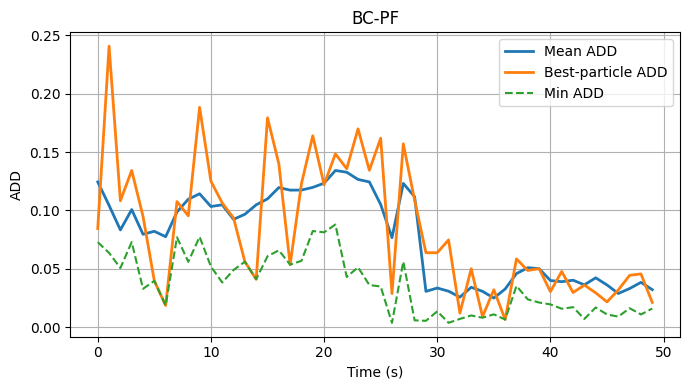

In [64]:
bc_pf_times, bc_pf_adds, bc_pf_add_mean, bc_pf_add_min, bc_pf_add_best = compute_add_over_time(
        bc_pf_res,
        gt_pose=gt_pose,
        model_mesh_path=rectangle.HOLE_OBJ,
        n_model_points=3000,
    )

plot_add_vs_time(times, bc_pf_add_mean, bc_pf_add_min, bc_pf_add_best, title="BC-PF")

### Compare min adds between methods

In [65]:
# Example: results from multiple experiments
min_adds = {
    "ICP": icp_add_min,      # shape (K,)
    "FP": fp_add_min,  # shape (K,)
    "BC-PF": bc_pf_add_min,            # shape (K,)
}
def plot_final_min_add_bars(min_adds_dict, title, mode="final"):
    """
    mode:
      - "final": last timestep
      - "best": global minimum
    """
    labels = []
    values = []

    for name, adds in min_adds_dict.items():
        labels.append(name)
        if mode == "final":
            values.append(adds[-1])
        elif mode == "best":
            values.append(np.min(adds))
        else:
            raise ValueError("mode must be 'final' or 'best'")

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values)
    plt.ylabel("Avg ADD")
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

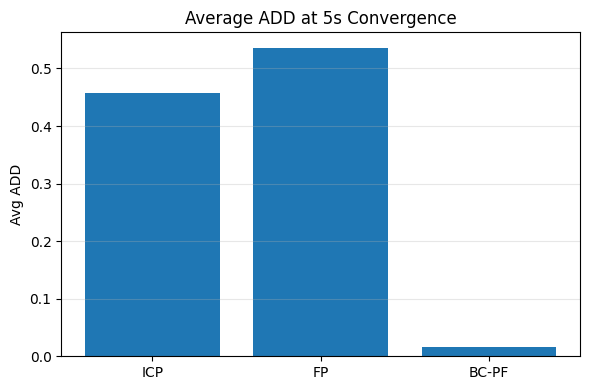

In [66]:
plot_final_min_add_bars(min_adds, title="Average ADD at 5s Convergence")

### ADD distribution over time

The following plots visualises how ADD is distributed over time

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_ridge_dataframe(adds_over_time, times):
    print(adds_over_time.shape)
    print(adds_over_time.reshape(-1).shape)
    T, N = adds_over_time.shape
    df = pd.DataFrame({
        "ADD": adds_over_time.reshape(-1),
        "time": np.repeat(times, N)
    })
    return df


def plot_add_ridge(df, time_stride=1):
    """
    df must contain columns: ['ADD', 'time']
    """

    # Optionally subsample times to avoid overcrowding
    unique_times = np.sort(df["time"].unique())
    keep_times = unique_times[::time_stride]
    df = df[df["time"].isin(keep_times)]

    g = sns.FacetGrid(
        df,
        row="time",
        hue="time",
        aspect=5,
        height=0.6,
        palette="viridis"
    )

    g.map(
        sns.kdeplot,
        "ADD",
        bw_adjust=0.8,
        fill=True,
        alpha=0.9,
        linewidth=1
    )

    g.map(plt.axhline, y=0, lw=0.5, clip_on=False)

    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.set_xlabels("ADD")

    g.fig.subplots_adjust(hspace=-0.7)
    plt.suptitle("Particle ADD Distribution Over Time", y=1.02)
    plt.show()


In [105]:

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
import matplotlib.pyplot as plt

def make_ridge_df(adds_tn: np.ndarray, times_t: np.ndarray | None = None) -> pd.DataFrame:
    """
    adds_tn: shape (T, N)  -> ADD values per time step per particle
    times_t: shape (T,)    -> time stamps (optional). If None, uses 0..T-1.
    Returns long-form df with columns: ['t', 'ADD'] where each row is one particle at one time.
    """
    adds_tn = np.asarray(adds_tn)
    if adds_tn.ndim != 2:
        raise ValueError(f"adds_tn must be (T,N). Got {adds_tn.shape}")
    T, N = adds_tn.shape

    if times_t is None:
        times_t = np.arange(T)
    times_t = np.asarray(times_t)
    if times_t.shape != (T,):
        raise ValueError(f"times_t must be (T,). Got {times_t.shape}, expected ({T},)")

    # long-form: repeat each time N times; flatten all ADDs
    df = pd.DataFrame({
        "t": np.repeat(times_t, N),
        "ADD": adds_tn.reshape(-1),
    })
    return df

def ridgeplot_add(df: pd.DataFrame, every: int = 1, bw_adjust: float = 0.8):
    """
    df: output of make_ridge_df with columns ['t','ADD'].
    every: plot every k-th time step to reduce clutter.
    """
    # pick which time steps to keep
    unique_t = np.sort(df["t"].unique())
    keep_t = unique_t[::max(1, every)]
    dff = df[df["t"].isin(keep_t)].copy()

    # Make 't' categorical so FacetGrid doesn't collapse/merge weird float times
    dff["t"] = pd.Categorical(dff["t"], categories=keep_t, ordered=True)

    #g = sns.FacetGrid(dff, row="t", height=0.5, aspect=15, sharex=True, sharey=False)
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(dff, row="t", hue="t", aspect=15, height=.5, palette=pal)
    g.map_dataframe(sns.kdeplot, x="ADD", fill=True, bw_adjust=bw_adjust, linewidth=1)
    g.map(plt.axhline, y=0, lw=0.5, clip_on=False)
    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    
    
    g.map(label, "ADD")

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    # g.set_titles(row_template="t = {row_name}")
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    #g.set_xlabels("ADD")
    g.despine(bottom=True, left=True)
    g.fig.subplots_adjust(hspace=-0.4)
    plt.show()

/root/.pyenv/versions/3.11.12/envs/inv_env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/root/.pyenv/versions/3.11.12/envs/inv_env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/root/.pyenv/versions/3.11.12/envs/inv_env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/root/.pyenv/versions/3.11.12/envs/inv_env/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

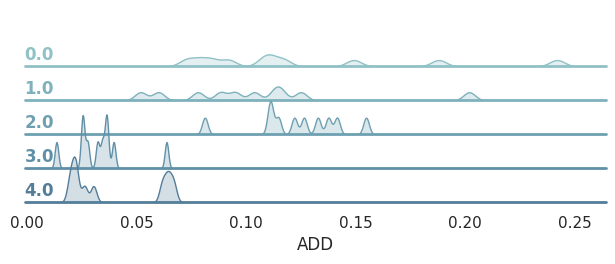

In [106]:
df = make_ridge_df(bc_pf_adds, bc_pf_times)
ridgeplot_add(df, every=10, bw_adjust=0.1)

# Tables

This section will output tables to be added to the paper

In [44]:
import pandas as pd

In [45]:
def min_add_table_pandas(min_adds_dict):
    """
    Args:
        min_adds_dict: dict
            method_name -> min_adds array, shape (K,)

    Returns:
        pd.DataFrame with methods as rows
    """

    records = []
    for method, adds in min_adds_dict.items():
        adds = np.asarray(adds)

        records.append({
            "method": method,
            "min_ADD": np.min(adds),
            "final_ADD": adds[-1],
            "mean_ADD": np.mean(adds),
        })

    df = pd.DataFrame(records).set_index("method")

    return df

df = min_add_table_pandas(min_adds)
print(df)

         min_ADD  final_ADD  mean_ADD
method                               
ICP     0.206780   0.460089  0.407484
FP      0.536206   0.536206  0.539625
BC-PF   0.003614   0.015892  0.035998
